# ANLP Assignment (Autumn 2020)

For assessment, you are expected to complete and submit this notebook file. When answers require code, you may import and use library functions (unless explicitly told otherwise). All of your own code should be included in the notebook rather than imported from elsewhere. Written answers should also be included in the notebook. You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers. If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data. In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell. Otherwise do not change the code in these cells.

In [ ]:
candidateno=234717 #this MUST be updated to your candidate number so that you get a unique data sample

In [ ]:
#set up drives for resources.  Change the path as necessary

from google.colab import drive
#mount google drive
drive.mount('/content/drive/')
import sys
sys.path.append('/content/drive/My Drive/Sussex AI/Applied NLP/1st Assignment/resources/')


Mounted at /content/drive/


In [ ]:
#do not change the code in this cell
#preliminary imports

import re
import random
from random import sample
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import zip_longest
from collections import defaultdict
from itertools import product
import operator
from scipy.stats import spearmanr

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('wordnet_ic')
nltk.download('universal_tagset')
from nltk.classify.api import ClassifierI
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic as wn_ic
from nltk import FreqDist
from nltk import pos_tag
from nltk import NaiveBayesClassifier
brown_ic = wn_ic.ic("ic-brown.dat")

from sussex_nltk.corpus_readers import AmazonReviewCorpusReader
from sussex_nltk.corpus_readers import ReutersCorpusReader

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet_ic to /root/nltk_data...
[nltk_data]   Package wordnet_ic is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


# Question 1: Books vs DVDs

In this question, you will be investigating NLP methods for distinguishing reviews written about books from reviews written about DVDs.

In [ ]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the 
            pair is a list of the training data and the second is a list of the test data.
    """
    
    data = list(data)  
    n = len(data)  
    train_indices = random.sample(range(n), int(n * ratio))          
    test_indices = list(set(range(n)) - set(train_indices))    
    train = [data[i] for i in train_indices]           
    test = [data[i] for i in test_indices]             
    return (train, test)                       
 

def feature_extract(review):
    """
    Generate a feature representation for a review
    :param review: AmazonReview object
    :return: dictionary of Boolean features
    """
    return {word:True for word in review.words()}

def get_training_test_data(categories=('book','dvd'),ratio=0.7,seed=candidateno):
    """
    Get training and test data for a given pair of categories and ratio, pre-formatted for use with NB classifier
    :param category: pair of categories of review corpus, two from ["kitchen, "dvd, "book", "electronics"]
    :param ratio: proportion of data to use as training data
    :return: pair of lists 
    """
    random.seed(candidateno)

    train_data=[]
    test_data=[]
    for category in categories:
      reader=AmazonReviewCorpusReader().category(category)    
      train, test = split_data(reader.documents(),ratio=ratio)
   
      train_data+=[(feature_extract(review),category)for review in train]
      test_data+=[(feature_extract(review),category)for review in test]
    random.shuffle(train_data)
    random.shuffle(test_data)

    return train_data,test_data

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [ ]:
#do not change the code in this cell
training_data,testing_data=get_training_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 6526
The amount of testing data is 2799
The representation of a single data item is below
({'My': True, 'favorite': True, 'Vince': True, 'Flynn': True, 'book': True, 'is': True, 'still': True, '``': True, 'Term': True, 'Limits': True, ',': True, 'but': True, 'I': True, 'really': True, 'enjoyed': True, 'Act': True, 'of': True, 'Treason': True, 'and': True, 'am': True, 'anxiously': True, 'awaiting': True, 'Mr.': True, "'s": True, 'next': True, 'Mitch': True, 'Rapp': True, 'novel': True, '.': True, 'Highly': True, 'recommended': True}, 'book')


a) Use your training data to find
i) the top 20 words which occur more frequently in book reviews than in dvd reviews
ii) the top 20 words which occur more frequently in dvd reviews than book reviews
Discuss what pre-processing techniques you have applied (or not applied) in answering this question, and why. [10 marks]

In [ ]:
def normalise(tokenlist):
  """
  normalise data
  """
  tokenlist=[str(token) if type(token) == int else token for token in tokenlist]
  tokenlist=["NUM" if token.isdigit() else token for token in tokenlist]
  tokenlist=["Nth" if (token.endswith(("nd","st","th")) and token[:-2].isdigit()) else token for token in tokenlist]
  tokenlist=["NUM" if re.search("^[+-]?[0-9]+\.[0-9]",token) else token for token in tokenlist]
  tokenlist=[token.lower() for token in tokenlist]
  return tokenlist

def filter_stopwords(tokenlist):
  """
  filter stopwords
  """
  tokenlist = [token for token in tokenlist if token not in stopwords.words('english') and token.isalpha()]
  return tokenlist

def get_wordnet_pos(treebank_tag):
  """
  simplify tags
  """
  if treebank_tag.startswith('A'):
      return 'a'
  elif treebank_tag.startswith('V'):
      return 'v'
  elif treebank_tag.startswith('N'):
      return 'n'
  elif treebank_tag.startswith('R'):
      return 'r'
  else:
      return 'n'

def pre_process(data):
  """
  Pre-process the given data
  """
  # apply lower casing, eliminate stopwords and numbers, and lemmatize words
  pre_process_docs = [(pos_tag(filter_stopwords(normalise(list(doc.keys()))), tagset='universal_tagset'), label) for (doc,label) in data]

  wnl = WordNetLemmatizer()
  pre_process_docs = [({(wnl.lemmatize(word, pos=get_wordnet_pos(tag))):True for (word,tag) in doc}, label) for doc,label in pre_process_docs]

  return pre_process_docs 

**Pre-processing applied**

I have applied several pre-processing techniques to both the training and testing data. First, I have normalized the data in order to convert every cardinal and ordinal numbers to either the string “NUM” or “Nth”. The reason to do that is that usually it is not important to know the value of a number but just that it is a number. After that, I have applied lower casing to all the tokens in order to avoid having several token types for the same word (e.g., ‘the’ in the middle of a sentence and ‘The’ in the beginning. Both type tokens should be considered as being instances of the same type).  

Once normalization has been done, I proceed to remove the stopwords. When generating the word list for each class of the calssifier, we are interested in those words that are relevant in each class. Since stopwords are usually among the most frequent words in a corpus, they are very likely to be considered when creating a frequency list for each class. Thus, I have removed the in order to only obtain the most frequent words for each class. 

Since I have used lemmatization and it is necessary to specify a part-of-speech tag as a parameter (otherwise it will treat all words as nouns, which is the default POS tag), I have used the NLTK POS tagger to obtain the 'universal' tag for each word. However, the NLTK lemmatizer only accpets few basic POS tags. Due to this, I have convert the 'universal' tags to simple ones. After this, I have lemmatized every word. I used lemmatization over stemming because with stemming, several words that can probably be considered of the same type appeared in the word list. Thus, although it is computationally more expensive (e.g., computing tags and simplifying them afterwards), I consider that better word lists are obtained. 

In [ ]:
# pre-process training and test data
pre_proc_train = pre_process(training_data)
pre_proc_test = pre_process(testing_data)

In [ ]:
def get_class(train_data):
  """
  get the class labels of the training data
  """
  labels = []
  for doc,label in train_data:
    if label not in labels:
      labels.append(label)

  return labels

In [ ]:
# get class labels
labels = get_class(training_data)
labels

['book', 'dvd']

In [ ]:
def check_balance_classes(train_data):
  """
  check how many documents in the training data belong to each class
  to see whether the training data is balanced or unbalanced
  """
  c1, c2 = get_class(train_data)
  class_1 = len([label for doc,label in training_data if label == c1])
  class_2 = len([label for doc,label in training_data if label == c2])

  return (c1, class_1), (c2, class_2)

In [ ]:
# check class balance
balance = check_balance_classes(training_data)
balance

(('book', 2683), ('dvd', 3843))

In [ ]:
def more_frequent(train_data, k):
  """
  given the training data, and a top k number of most frequent words, returns
  two lists:
  1) k most frequent words in class 1 of the training data than class 2
  2) k most frequent words in class 2 of the training data than class 1
  """
  train_freq = {}
  # for each review in the training data, create a dictionary of word frequencies
  # that will be the 'value' of the 'train_freq' dictionary with the review label
  # as key of the nested dictionary (e.g., dict = {label:{word1:freq1, word2:freq2}})
  for (doc,label) in train_data:
      doc_freq = train_freq.get(label,{})
      for word in doc.keys():
          doc_freq[word] = doc_freq.get(word,0) + 1
    
      train_freq[label] = doc_freq

  # get class labels
  label1, label2 = list(train_freq.keys())
  # compute the frequency difference between words in each class
  class_1 = [(word,freq - train_freq[label2].get(word, 0)) for word,freq in train_freq[label1].items()]
  class_2 = [(word,freq - train_freq[label1].get(word, 0)) for word,freq in train_freq[label2].items()]
  # descending sort of the lists of tuples above by the second value, which is the frequency
  ks_class_l = sorted(class_1,key=lambda pair:pair[1], reverse=True)[:k]
  ks_class_2 = sorted(class_2,key=lambda pair:pair[1], reverse=True)[:k]

  return (label1, ks_class_l), (label2, ks_class_2)

In [ ]:
# Obtain the 20th more frequent terms in each class ('book' and 'dvd')
result = more_frequent(pre_proc_train, 20)
# Store labels of each class and the each list of k more frequent terms
labs = [labels[0], 'frequency', labels[1], 'frequency']
list_freqs = [result[ind][1] for ind in range(len(result))]
# unify in a single tuple every pair of tuples from each list
values = [x + (y,z) for x, (y, z) in zip(list_freqs[0], list_freqs[1])]
# Show in a pandas dataframe the k more frequent terms in each class
df = pd.DataFrame(values, columns=labs)
display(df) 

,book,frequency,dvd,frequency
0,book,1939,movie,1837
1,read,961,film,1312
2,author,481,dvd,1031
3,reading,466,watch,713
4,reader,351,num,696
5,page,308,one,574
6,writing,225,see,554
7,written,221,scene,532
8,chapter,181,great,531
9,novel,178,like,515


b) Design, build and test a word list classifier to classify reviews as being from the book domain or from the dvd domain.  Make sure you discuss i) how you decide the lengths and contents of the word lists and ii) accuracy, precision and recall of your final classifier.[15 marks]

In [ ]:
class SimpleClassifier(ClassifierI): 
  """
  Class for a binary classifier that classifies based on words lists
  """
  def __init__(self):
    """
    set labels
    """
    self.labels = ['book', 'dvd']

  def classify(self, doc): 
    """
    given a document, it is classified as either belonging to one of the two
    classes
    """
    score = 0
    for w in doc:
      if w in self.class_1_k_frequent:
        score += 1
      elif w in self.class_2_k_frequent:
        score -= 1
    
    # assign class according to score
    if score > 0:
      return self.labels[0]
    elif score < 0:
      return self.labels[1]
    else:
      # if the score is zero, classify randomly
      return random.choice(self.labels)

  def train(self, train_data, k):
    """
    given the training data, and a top k number of most frequent words, returns
    two lists:
    1) k most frequent words in class 1 of the training data than class 2
    2) k most frequent words in class 2 of the training data than class 1
    """
    train_freq = {}
    # for each review in the training data, create a dictionary of word frequencies
    # that will be the 'value' of the 'train_freq' dictionary with the review label
    # as key of the nested dictionary (e.g., dict = {label:{word1:freq1, word2:freq2}})
    for (doc,label) in train_data:
        doc_freq = train_freq.get(label,{})
        for word in doc.keys():
            doc_freq[word] = doc_freq.get(word,0) + 1
      
        train_freq[label] = doc_freq

    # get class labels
    label_1 = self.labels[0]
    label_2 = self.labels[1]
    # compute the frequency difference between words in each class
    class_1 = [(word,freq - train_freq[label_2].get(word, 0)) for word,freq in train_freq[label_1].items()]
    class_2 = [(word,freq - train_freq[label_1].get(word, 0)) for word,freq in train_freq[label_2].items()]
    # descending sort of the lists of tuples above by the second value, which is the frequency
    class_1_k_frequent = sorted(class_1,key=lambda pair:pair[1], reverse=True)[:k]
    class_2_k_frequent = sorted(class_2,key=lambda pair:pair[1], reverse=True)[:k]

    self.class_1_k_frequent = [word for word,freq in class_1_k_frequent]
    self.class_2_k_frequent = [word for word,freq in class_2_k_frequent]

In [ ]:
class ConfusionMatrix:
  """
  Class to obtain different metric measures
  """
  def __init__(self,predictions,goldstandard,classes=("book","dvd")):
      """
      The 'positive' class is the 'book' review, and the negative, the 'dvd'
      review.
      """
      (self.c1,self.c2)=classes
      self.TP=0
      self.FP=0
      self.FN=0
      self.TN=0
      self.preds = predictions
      self.gold = goldstandard
      for p,g in zip(predictions,goldstandard):
          if g==self.c1:
              if p==self.c1:
                  self.TP+=1
              else:
                  self.FN+=1
          
          elif p==self.c1:
              self.FP+=1
          else:
              self.TN+=1

  def accuracy(self):
    """
    compute accuracy
    """
    return sum(x == y for x, y in zip(self.preds, self.gold)) / len(self.gold)
      
  
  def precision(self):
    """
    compute precission
    """
    p = 0 
    p = (self.TP / (self.TP + self.FP))
    self.p = p
    return p
  
  def recall(self):
    """
    compute recall
    """
    r = 0
    r = (self.TP / (self.TP + self.FN))
    self.r = r
    return r
  
  def f1(self):
    """
    compute f1 score
    """
    f1=0
    # compute f1 here
    f1 = 2*self.r*self.p / (self.r + self.p)
      
    return f1 

In [ ]:
def get_metrics(predictions, gold):
  """
  given a set of predictions and the goldstandard labels, it computes
  four different metrics:
  - accuracy
  - precission
  - recall
  - f1 score
  """
  cm = ConfusionMatrix(predictions, gold)
  return [cm.accuracy(), cm.precision(), cm.recall(), cm.f1()]

In [ ]:
def test_ks_frequent(train_data, test_data, gold, ks):
  """
  using the whole training data, test the classifier using different k
  """
  sc = SimpleClassifier()
  predict_ks = []
  metrics = []
  for k in ks:
    sc.train(train_data, k)
    predictions_sc = [sc.classify(doc) for doc,label in test_data]
    predict_ks.append(predictions_sc)
    metrics.append(get_metrics(predictions_sc, gold))

  return metrics, predict_ks

In [ ]:
def get_gold(data):
  """
  get goldstandard labels
  """
  return [label for doc,label in data]

In [ ]:
gold = get_gold(pre_proc_test)

Since classes are rather balanced, I will choose the accuracy as the metric to set the best parameter k in each training sample size

In [ ]:
def get_best_k(ks, accuracies):
  """
  get the best parameter k for each training sample based on the accuracy
  of the classifier
  """
  ks_accuracies = list(zip(ks, accuracies))
  return max(ks_accuracies, key=lambda t:t[1])[0]

In [ ]:
# train and classify test data using simple classifier with different k values
ks = list(range(1, 110, 10))
metrics_sc, predictions_sc = test_ks_frequent(pre_proc_train, pre_proc_test, gold, ks)

In [ ]:
# get accuracies to obtain the best k in this sample data
accuracies = [metrics[0] for metrics in metrics_sc]
best_k = get_best_k(ks, accuracies)

,k,Accuracy,Precision,Recall,F1
0,1,0.803501,0.705963,0.894874,0.789272
1,11,0.866024,0.932071,0.727194,0.816984
2,21,0.803144,0.950450,0.549957,0.696753
3,31,0.793855,0.947040,0.528236,0.678193
4,41,0.767060,0.947935,0.458732,0.618267
5,51,0.755270,0.948077,0.428323,0.590066
6,61,0.731690,0.960829,0.362294,0.526183
7,71,0.715255,0.958549,0.321460,0.481457
8,81,0.704537,0.955056,0.295395,0.451228
9,91,0.692033,0.950156,0.264987,0.414402


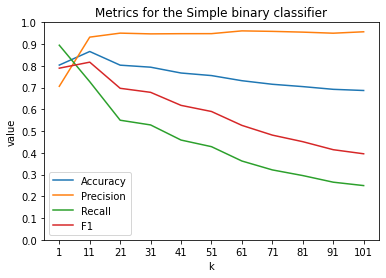

In [ ]:
# zip k values with the metrics
values = [[x] + y for x,y in zip(ks, metrics_sc)]
cols = ['k', 'Accuracy', 'Precision', 'Recall', 'F1']
# create pandas dataframe to show the metrics for the simple classifier
df = pd.DataFrame(values, columns=cols)
display(df) 

# create a plot bar to show the value of each metric for the simple classifier
for ind in range(len(metrics_sc[0])):
  plt.plot(ks,[metric[ind] for metric in metrics_sc],label = cols[ind + 1])
  
plt.title('Metrics for the Simple binary classifier')
plt.xlabel('k')
plt.ylabel('value')
plt.legend(loc='best')
plt.xticks(ks)
plt.yticks(np.arange(0, 1.01, 0.1))
plt.show()

**Discussion**: Here I have considered that the possitive class is 'book'. From the k more frequent words, it can be observed that words in the 'book' class occur, except from the first few words, occur have a less frequency than the words from the 'dvd' list. In the 'dvd' calss, even the less more frequent words still occur much more frequently than in book reviews. This explains the values of precission, recall, and f1 as k increases. The word list for book reviews will match only the most relevant words related to book reviews because less common words might occur more in the dvd review. This means that in book reviews there are less class relevant words than in dvd reviews. Thus, there are less words used in book reviews that occur much more frequently in dvd reviews than words used in dvd reviews that occur much more frequently than book reviews. That is why a lot of book reviews might contain the word 'great', but since it is more used in dvd reviews, it might be the case that a book reviews that could be characterized by that word will be categorized as a dvd review. 

Therefore, having words that are less more frequent results in a higher probability of not categorizing a true review as true. This implies that only very specific reviews will be correctly categorized (high precision) and, as a consequence, there will be a lot of 'misses' (low recall). The inverse happens with the 'negative' class (dvd reivews). Similarly, it is expected to observe recall and f1 score decreases as k increases. 

c) Compare the performance of your word list classifier with a Naive Bayes classifier (e.g., from NLTK).  Make sure you discuss the results. [10 marks]

,metric,value
0,Accuracy,0.931404
1,Precision,0.934723
2,Recall,0.895743
3,F1,0.914818


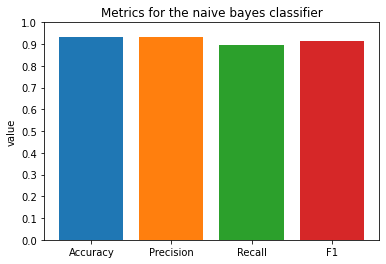

In [ ]:
# train and classify test data using simple classifier
train_nbc = NaiveBayesClassifier.train(pre_proc_train)
predictions_nbc = [train_nbc.classify(doc) for doc,label in pre_proc_test]

# store metrics for naive bayes classsifier
metrics_nbc = get_metrics(predictions_nbc, gold)

# labels for each metric measure
labs = cols[1:]

# create pandas dataframe to show the metrics for naive bayes classifier
df = pd.DataFrame(zip(labs,metrics_nbc), columns=['metric', 'value'])
display(df) 

# create a plot bar to show the value of each metric for naive bayes classifier
for ind in range(len(labs)):
  plt.bar(labs[ind], metrics_nbc[ind])

plt.title('Metrics for the naive bayes classifier')
plt.ylabel('value')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

**DISCUSS**
The Naïve Bayes classifier performs better than the Simple classifier (no matter the k chosen) in all metrics except from the precission (due to the reasons explained above). It shows that a classifier based on the probability distribution of the words ind documents and classes returns better results that a classifier baseed on word lists.

d) Design and carry out an experiment into the impact of the amount of training data on each of these classifiers.  Make sure you describe design decisions in your experiment, include a graph of your results and discuss your conclusions. [15 marks] 

**Experiment**: I will train each of the classifiers using random samples of data of different sizes. moreover, for the Simple classifier, I will compute the best parameter k for each training sample. After that, I will compute the metrics obtained by each classifier for each training sample size. by doing that, I expect to observe how the performance of each classifier varies depending on the amount of training data used.

In [ ]:
def predictions(train_data, test_data, classifier, k):
  """
  Given the selected classifier, it is trained and used to classify the test data
  """
 
  if 'NaiveBayesClassifier' in str(classifier):
    cl = classifier.train(train_data)
    predict = [cl.classify(doc) for doc,label in test_data]

  elif 'SimpleClassifier' in str(classifier):
    cl = classifier()
    cl.train(train_data, k)
    predict = [cl.classify(doc) for doc,label in test_data]

  else:
    return 'Classifier not admitted. Try \'NaiveBayesClassifier\' or \'SimpleClassifier\'.'

  return predict


In [ ]:
def systematic_test(train_data, test_data, sizes, ks, gold):
  """
  Compare the performance of each classifier for different training sample sizes.
  For the simple classifier, it is used the best k (calling the function
  described above) for each training sample size
  """
  sc_metrics = []
  nbc_metrics = []
  ks_used = []
  sc = SimpleClassifier()
  for n in sizes:
    # get a random sample from the training data
    train = sample(train_data, n)

    # calculate metrics and predictions for the current train sample using
    # different k in Simple classifier. Then, use the best k to store the
    # predictions made corresponding to the current training sample
    metrics_sc, predictions_sc = test_ks_frequent(train, test_data, gold, ks)
    accuracies = [metrics[0] for metrics in metrics_sc]
    best_k = get_best_k(ks, accuracies)
    k_index = ks.index(best_k)
    predictions_sc = predictions_sc[k_index]

    # train and classify using Naive Bayes classifier
    nbc = NaiveBayesClassifier.train(train)
    predictions_nbc = predictions(train, test_data, NaiveBayesClassifier, None)
    
    # store metrics of each classifier for the current training sample
    sc_metrics.append(get_metrics(predictions_sc, gold))
    nbc_metrics.append(get_metrics(predictions_nbc, gold))
    ks_used.append(best_k)

  return sc_metrics, nbc_metrics, ks_used

In [ ]:
# Predictions of Simple and Naive Bayes classifier for different training data sizes
# choosing in each training sample the best k
sample_sizes = list(map(int, np.linspace(10, len(pre_proc_train), 50)))
sc_met, nbc_met, ks_used = systematic_test(pre_proc_train, pre_proc_test, 
                           sample_sizes, ks, gold)

,Sample,Best k,Accuracy SC,Precision SC,Recall SC,F1 SC,Accuracy NBC,Precision NBC,Recall NBC,F1 NBC
0,10,1,0.788139,0.688005,0.887055,0.774953,0.696677,0.582604,0.925282,0.715005
1,142,11,0.848875,0.871429,0.741964,0.801502,0.892462,0.901701,0.828844,0.863739
2,275,11,0.880672,0.907278,0.790617,0.844940,0.896034,0.928287,0.809731,0.864965
3,408,21,0.859593,0.923937,0.717637,0.807824,0.903894,0.865672,0.907037,0.885872
4,541,11,0.853876,0.908590,0.716768,0.801360,0.911754,0.886986,0.900087,0.893489
5,674,11,0.862451,0.918122,0.730669,0.813740,0.902108,0.931170,0.822763,0.873616
6,807,11,0.835298,0.916667,0.659427,0.767054,0.884244,0.950927,0.757602,0.843327
7,940,11,0.845659,0.920468,0.683753,0.784646,0.919257,0.931839,0.867072,0.898290
8,1073,11,0.854234,0.908691,0.717637,0.801942,0.915327,0.918498,0.871416,0.894338
9,1206,11,0.854234,0.925544,0.701998,0.798419,0.912469,0.944990,0.835795,0.887045


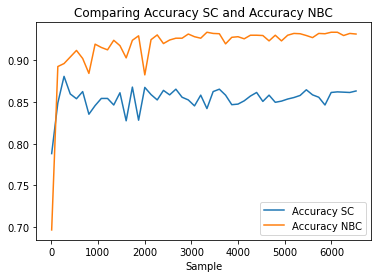

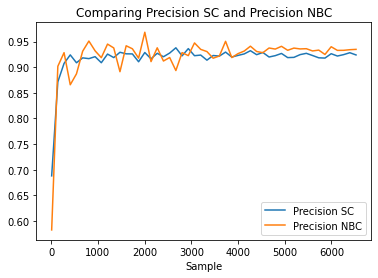

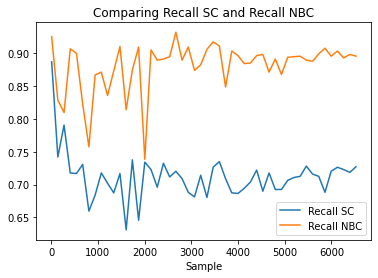

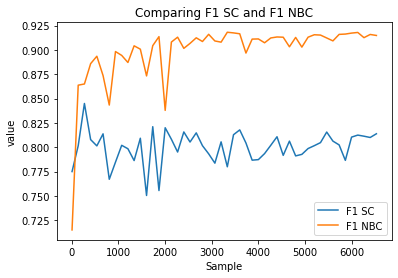

In [ ]:
# zip ks with results and then zip sample_sizes with the result of the previous
# zip
ks_with_results = [[x]+y+z for x,y,z in zip(ks_used, sc_met, nbc_met)] 
ss_ks_results = [[x]+y for x,y in zip(sample_sizes, ks_with_results)]

cols = ["Sample", "Best k", "Accuracy SC","Precision SC","Recall SC",
        "F1 SC", "Accuracy NBC", "Precision NBC", "Recall NBC","F1 NBC"]

df = pd.DataFrame(ss_ks_results,columns = cols)
display(df)
for ind in range(2, len(cols) - 4):
  ax = df.plot(kind='line',x = 'Sample',y=[cols[ind], cols[ind + 4]],
               title="Comparing " + cols[ind] + " and " + cols[ind + 4])

# set the y-axis label
ax.set_ylabel("value")
# set the y axis range 
ax.legend(loc='best')
plt.show()

**Results**

Regarding the Naïve Bayes classifier, its metrics are rather irregular for small training samples sizes. This could be due to the probabilistic nature of this classifier. Since it is based on the priors and posteriors, the probability distribution of both the classes and the words in them can vary a lot when the sample is small. However, as can be seen in all metrics, it always converges to some value as the sample size increases. As the sample gets bigger, the probability distributions tend to converge to some values that barely vary, and thus, the performance of the Naïve Bayes classifier stabilizes. 

Similarly, for the Simple classifier it can also be observed a tendency towards some specific range of values in all the metrics. For smaller training samples, it is possible that some of the classes might be underrepresented, while for larger training samples, both classes tend to occur the expected number of times.

The performance of the Naïve Bayes classifier is slightly better for all metrics, except for the precision. As explained above, the word frequencies in both lists are very different, except from the first few terms. Thus, since the positive class is considered to be ‘book’, which has a word list with lower frequencies, it is expected that, among the documents that are clearly related to the ‘book’ class, the Simple classifier will classify them as ‘book’ (high precision). However, there will be a lot of misses regarding this class (low recall), which will be classified as belonging to the other class. 
Overall, since classes are quite balanced, it can be concluded, based on the accuracy, that the Naïve Bayes classifier performs better than the Simple classifier for large enough training samples. 


# Question 2: Distributional Semantics

In this question, you will be investigating the *distributional hypothesis*: **words which appear in similar contexts tend to have similar meanings**.

We are going to be using the Reuters corpus of financial documents for this part of the assignment.  When you run the following cell you should see that it contains 1,113,359 sentences.

In [ ]:
#do not change the code in this cell
rcr = ReutersCorpusReader().finance()
rcr.enumerate_sents()

1113359

The following cell will take 2-5 minutes to run.  It will generate a unique-to-you sample of 200,000 sentences.  These sentences are tokenised and normalised for case and number for you.

In [ ]:
#do not change the code in this cell
def normalise(tokenlist):
    tokenlist=[token.lower() for token in tokenlist]
    tokenlist=["NUM" if token.isdigit() else token for token in tokenlist]
    tokenlist=["Nth" if (token.endswith(("nd","st","th")) and token[:-2].isdigit()) else token for token in tokenlist]
    tokenlist=["NUM" if re.search("^[+-]?[0-9]+\.[0-9]",token) else token for token in tokenlist]
    return tokenlist

random.seed(candidateno)  
samplesize=2000
iterations =100
sentences=[]
for i in range(0,iterations):
    sentences+=[normalise(sent) for sent in rcr.sample_sents(samplesize=samplesize)]
    print("Completed {}%".format(i))
print("Completed 100%")


Completed 0%
Completed 1%
Completed 2%
Completed 3%
Completed 4%
Completed 5%
Completed 6%
Completed 7%
Completed 8%
Completed 9%
Completed 10%
Completed 11%
Completed 12%
Completed 13%
Completed 14%
Completed 15%
Completed 16%
Completed 17%
Completed 18%
Completed 19%
Completed 20%
Completed 21%
Completed 22%
Completed 23%
Completed 24%
Completed 25%
Completed 26%
Completed 27%
Completed 28%
Completed 29%
Completed 30%
Completed 31%
Completed 32%
Completed 33%
Completed 34%
Completed 35%
Completed 36%
Completed 37%
Completed 38%
Completed 39%
Completed 40%
Completed 41%
Completed 42%
Completed 43%
Completed 44%
Completed 45%
Completed 46%
Completed 47%
Completed 48%
Completed 49%
Completed 50%
Completed 51%
Completed 52%
Completed 53%
Completed 54%
Completed 55%
Completed 56%
Completed 57%
Completed 58%
Completed 59%
Completed 60%
Completed 61%
Completed 62%
Completed 63%
Completed 64%
Completed 65%
Completed 66%
Completed 67%
Completed 68%
Completed 69%
Completed 70%
Completed 71%
Co

`generate_features()` will used and explored below.

In [ ]:
# do not change the code in this cell
def generate_features(sentences,window=1):
    mydict={}
    for sentence in sentences:
        for i,token in enumerate(sentence):
            current=mydict.get(token,{})
            features=sentence[max(0,i-window):i]+sentence[i+1:i+window+1]
            for feature in features:
                current[feature]=current.get(feature,0)+1
            mydict[token]=current
    return mydict

In [ ]:
# preprocessing sentences: removing stopwords
sentences = [filter_stopwords(sentence) for sentence in sentences]

a) Run `generate_features(sentences[:5])`. With reference to the code and the specific examples, explain how the output was generated [5 marks]

In [ ]:
print(sentences[:5])
generate_features(sentences[:5])

[['current', 'transfers', 'NUM', 'NUM', 'NUM'], ['georgia', 'shevardnadze', 'seeks', 'investment'], ['georgia', 'lost', 'control', 'abkhazia', 'lush', 'subtropical', 'region', 'disorganised', 'military', 'driven', 'NUM', 'year', 'fighting', 'killed', 'people'], ['milwaukee', 'cty', 'NUM', 'mln', 'abn', 'amro'], ['another', 'dealer', 'said', 'issue', 'reoffered', 'NUM', 'basis', 'points', 'spread', 'testing', 'NUM']]


{'NUM': {'NUM': 4,
  'basis': 1,
  'cty': 1,
  'driven': 1,
  'mln': 1,
  'reoffered': 1,
  'testing': 1,
  'transfers': 1,
  'year': 1},
 'abkhazia': {'control': 1, 'lush': 1},
 'abn': {'amro': 1, 'mln': 1},
 'amro': {'abn': 1},
 'another': {'dealer': 1},
 'basis': {'NUM': 1, 'points': 1},
 'control': {'abkhazia': 1, 'lost': 1},
 'cty': {'NUM': 1, 'milwaukee': 1},
 'current': {'transfers': 1},
 'dealer': {'another': 1, 'said': 1},
 'disorganised': {'military': 1, 'region': 1},
 'driven': {'NUM': 1, 'military': 1},
 'fighting': {'killed': 1, 'year': 1},
 'georgia': {'lost': 1, 'shevardnadze': 1},
 'investment': {'seeks': 1},
 'issue': {'reoffered': 1, 'said': 1},
 'killed': {'fighting': 1, 'people': 1},
 'lost': {'control': 1, 'georgia': 1},
 'lush': {'abkhazia': 1, 'subtropical': 1},
 'military': {'disorganised': 1, 'driven': 1},
 'milwaukee': {'cty': 1},
 'mln': {'NUM': 1, 'abn': 1},
 'people': {'killed': 1},
 'points': {'basis': 1, 'spread': 1},
 'region': {'disorganised': 1, 'subtr

**Answer**: The function 'generate_features' generates a distributional represenation of every word contained in the input sentences based on their frequencies. A distributional representations (also known as vector representation) based on frecuencies counts the number of occurences of all features that appear in the same context than the target word (i.e., the word corresponding to the actual distributional representation). How is this context defined? The context is specified by setting a context or size window. Basically, the size of the window defines the number of features to the right and left of the target word that will be added to its vector representation. For instance, in function 'generate_features', the window size is set by default to 1, which means that only the features that are besides the target word (to its left or right) will be part of its distributional representation. 

Now that the basic concepts have been presented, I will explain how the function works. First, it receives two parameters: 'sentences' and 'window'. 'sentences' simply refers to the sample sentences from which the vector representations will be build. On the other hand, 'window' referes to the window size. The distributional representations are generated using a nested dictionary ('mydict'), where each key is the target word, and each value is another dictionary ('current'). In the latter dictionary, each key is a feature that, in some of the input sentences, has appeared in the same context than the target word; and each value is the frecuency of each feature (i.e., how many times has that featured occured in the same context than the target word). 

With the first loop it is accessed the content of each sentence. In the nested loop, it is used 'enumerate' to assign to each token in the sentecen its corresponding index. The method 'get' is used to store an empty dictionary in the variable 'current' if the current token is not a key in 'mydict'(current=mydict.get(token,{})). This dictionary will be used as a dictionary to add the features that appear in the same context than the current token (key) along withn their frecuency (value). After that, all the features within the context windows are stored in the variable 'features'. How? Two lists of features are added; one corresponding to the features on the left of the target word (sentence[max(0,i-window):i]) and the other to the right (sentence[i+1:i+window+1]). Once the features in the window context are defined, it is looped through all the features to add them as keys in the dictionary of the target word (current token) and add one to their current frecuency (dictionary value). Again, method 'get' (current[feature]=current.get(feature,0)+1) is used to add one to the frecuency of those features that have appeared for the first time in the context of the target word. 

Finally, the current token is added as key to 'mydict' and it is assigned as value the dictionary of feature frecuencies ('current'). By doing this, the vector representation of each word is created and constantly updated any time it appears in a sentence. 

Let's use the word 'basis' to see how its distributional representation based on frecuncy ohas been generated. Given a context window equal to one, the features added to 'basis' will be either words that appear on its left or on its right. In the following example, features 'x' and 'y' are in the window size of 'basis':
  
  - sentence[n] = [...,'x', 'basis', 'y',...]

Examining the first 5 sentences, it can be seen that the features that appear besides 'basis' are: 'NUM' and 'points'. Moreover, these features only appear once in the same context as 'basis'. Thus, the vector representation of this word is
  - 'basis': {'NUM': 1, 'points': 1}

which is the same vector representation that can be found when calling the function 'generate_features' with the input 'sentences[:5]'.


b) Write code and **find** the 1000 most frequently occurring words that
* are in your sample; AND
* have at least one noun sense according to WordNet [5 marks]

In [ ]:
def frequent_sense(sample, tag, k):
  """
  given a sample, a tag and some number k, computes the k most
  frequent words that have at least one noun sense
  """
  pos = {'NOUN':wn.NOUN, 'ADV':wn.ADV, 'ADJ':wn.ADJ, 'VERB':wn.VERB}
  freq_sense = []
  for sentence in sample:
    for word in sentence:
      if wn.synsets(word, pos=pos[tag]):
        freq_sense.append(word)

  fdist = FreqDist(freq_sense)
  
  return fdist.most_common(k)

In [ ]:
most_freq = frequent_sense(sentences, 'NOUN', 1000)
# most_freq

In [ ]:
# do not change the code in this cell.  It relates to part c)
wordpair=("house","garden")
concept_1=wn.synsets(wordpair[0])[0]
concept_2=wn.synsets(wordpair[1])[0]
print("Path similarity between 1st sense of {} and 1st sense of {} is {}".format(wordpair[0],wordpair[1],wn.path_similarity(concept_1,concept_2)))
print("Resnik similarity between 1st sense of {} and 1st sense of {} is {}".format(wordpair[0],wordpair[1],wn.res_similarity(concept_1,concept_2, brown_ic)))
print("Lin similarity between 1st sense of {} and 1st sense of {} is {}".format(wordpair[0],wordpair[1],wn.lin_similarity(concept_1,concept_2, brown_ic)))

Path similarity between 1st sense of house and 1st sense of garden is 0.08333333333333333
Resnik similarity between 1st sense of house and 1st sense of garden is 1.2900256809649917
Lin similarity between 1st sense of house and 1st sense of garden is 0.15380807721262396


c) 
i) The code above outputs the path similarity score, the Resnik similarity score and the Lin similarity score for a pair of concepts in WordNet.  Explain what each of these numbers means.

ii) For every possible pair of words identified in Q2, determine the semantic similarity of the pair according to WordNet.  Make sure you justify your choice of semantic similarity measure and explain and justify the strategy used for words with multiple senses.

iii) Identify the 10 most similar words (according to WordNet) to the most frequent word in the corpus [15 marks]

**c)**

**i)** 

**Path similarity**: $$sim_{path}(c_{1},c_{2}) = \frac{1}{1 + pathlen(c_{1},c_{2})}$$

Path length similarity is a semantic similarity measure based on the number of branches that separate two concepts in a hierarchical tree structure. The intuition behind this measure is that more similar concepts are closer in the hierarchy. As can be seen in the formula above, two concepts that are synonyms will have a path length similarity of 1, since both concepts are not separated by any branch; they are in the leaf. In this case, the path lenth  s equal to 0 and, therefore, the similarity is equal to 1. As two concepts are more distant from each other, their path len similarity decrease and tends to zero (the numerator is constant but the denominator gets bigger). The main disadvantage of this measure is that it only takes into account the length of the path that separates two concepts, but does not differentiate between the type or the height if the path in the hierarchy. Concepts separated by more different types of paths (e.g., path with only vertical direction) will be more dissimilar; and concepts higher in the hierarchy will also be more dissimilar since categories are broader and, thus, concepts will belong to more different categories than they do lower in the hierarchy. 

**Resnik Lin similarities**:

$$sim_{res}(c_{1},c_{2}) = IC(LCS(c_{1},c_{2}))$$

$$sim_{lin}(c_{1},c_{2}) = \frac{2sim_{res}(c_{1},c_{2})}{IC(c_{1}) + IC(c_{2})}$$

Both Resnik and Lin similarities are based on information content. Given two concepts, Resnik similarity measures the information content of their lowest common subsume. On the other hand, Lin similarity measures the ratio of the information they shared to the total information content (the sum of each information content). While Lin similarity overcomes the problems of path length similarity measured as mentioned above, Resnik still misrepresent the information content of two concepts in some cases. For instance, if two concepts have the same common least subsume, no matter how distant each of these two concepts is from their lowest common subsume, Resnik similarity will always return the same value. Why? Simply because Resnik similarity only computes information content of their lowest common subsumer; it is measuring an absolute value (can have values over 1), but not a relative one, as Lin does. On the contrary, Lin similarity computes the ratio, which does take into account how distant two concepts are from their lowest common subsumer (the is why the output values are always between 0 and 1). Therefore, I consider that using Lin similarity is the more optimal measure among these three.

In [ ]:
# get a list of the words (leaving frequencies aside) from the 1000 most frequent words
most_frequent_words = [word for word,freq in most_freq]

In [ ]:
def semantic_similarity(words, similarity='lin'):
  """
  Computes the selected semantic similarity between all pairs in a list of words
  """
  similarities = []
  measures = {'path':wn.path_similarity, 'res':wn.res_similarity, 'lin':wn.lin_similarity}
  # allowed part-of-speech taggers in the information content file 'brown_ic'
  allowed_pos = ['n', 'v']
  for i,word1 in enumerate(words):
    for word2 in words[i + 1:]:  
      concepts_1 = wn.synsets(word1)
      concepts_2 = wn.synsets(word2)
      synset_pairs = product(concepts_1, concepts_2)

      if similarity == 'res' or similarity == 'lin':
        simil = max([measures[similarity](synset1, synset2, brown_ic) for synset1,synset2 in synset_pairs
                    if synset1.pos() == synset2.pos() and synset1.pos() in allowed_pos])
        
      else:
        simil = max([measures[similarity](synset1, synset2) for synset1,synset2 in synset_pairs])

      similarities.append((word1,word2,simil))

  return similarities

In [ ]:
# get the semantic similarities between all pairs of words from the 
# 1000 most frequent words
sem_simil = semantic_similarity(most_frequent_words[:1000])

In [ ]:
def k_most_similar(similarities, most_frequent, k):
  """
  Given a list of semantic similarities between pairs of words, computes the 
  k most similar words to the most frequent
  """
  mydict = {}
  simil = [(w2,sim) if w1 == most_frequent else (w1,sim) if w2 == most_frequent else ('',0) for (w1,w2,sim) in sem_simil]
  sort_similarities = sorted(simil, key=lambda x: x[1], reverse=True)

  return sort_similarities[:k]

In [ ]:
# get the 10th most similar words from the 1000 most frequent words list
# to the most frequent word 
most_similar = k_most_similar(sem_simil, most_frequent_words[0], 10)
most_similar

[('pct', 1.0),
 ('percentage', 1.0),
 ('rate', 0.8713862139653964),
 ('rates', 0.8713862139653964),
 ('ratio', 0.864154123132271),
 ('average', 0.7688056689969761),
 ('c', 0.7157757549154073),
 ('pace', 0.6513567419934713),
 ('relations', 0.47473799276003187),
 ('part', 0.4543339945757353)]

d)
i) Write code to construct distributional vector representations of words in the corpus with a parameter to specify context size.  Explain how you calculate the value of association between each word and each context feature.

ii) Use your code to construct representations of the 1000 words identified in Q2 with a window size of 1 and thus determine the 10 words which are distributionally most similar to the most frequent word in the corpus. [10 marks]

**d)**

**i)** Pointwise Mutual Information (PMI):

There are two vector representations that can be built in this class. First, as explained above, the distributional representation based on frequencies is obtained by calling the function 'generate_features', which has been already explained. In addition, this vector representation based on frequencies can be converted to a vector representation based on the Pointwise Mutual Information (PMI). For each target word, it computes the PMI for each feature that appeared in its context window. The following formula computes the PMI:

$$I(w,f) = log\frac{freq(f,w)freq(*,*)}{freq(f,*)freq(*,w)}$$

The intuition behind PMI is that for every pair of word and feature, if the feature co-occurs with the target word more than if they co-occured independently, then this feature is considered to be more informative about the target wor; that feature should be considered to play a relevant role in fixing the meaning of the target word. 

In [ ]:
class word_vectors:
    """
    class that creates vector representations
    """
    def __init__(self,sentences,window=1):
      """
      initialize the class
      """
      self.sentences=sentences
      self.window=window
      self.reps={}
      self.wordtotals={}
      self.feattotals={}
      self.generate_features()
      self.grandtotal=sum(self.wordtotals.values())
      self.convert_to_ppmi()
    
    def generate_features(self):
      """
      get vector representations of the words based on frecuency
      """
      for sentence in self.sentences:
          for i,token in enumerate(sentence):
              current=self.reps.get(token,{})
              features=sentence[max(0,i-self.window):i]+sentence[i+1:i+self.window+1]
              for feature in features:
                  current[feature]=current.get(feature,0)+1
                  self.feattotals[feature]=self.feattotals.get(feature,0)+1
              self.wordtotals[token]=self.wordtotals.get(token,0)+len(features)
              self.reps[token]=current

    def convert_to_ppmi(self):
      """
      convert frecuencies of vector representation to PMI
      """
      self.ppmi={word:{feat:max(0,math.log((freq*self.grandtotal)/(self.wordtotals[word]*self.feattotals[feat]),2)) for (feat,freq) in rep.items()} for (word,rep) in self.reps.items()}
    
    def similarity(self,word1,word2):
      """
      computes the cosine similarity betweeen two words
      """
      rep1=self.ppmi.get(word1,{})
      rep2=self.ppmi.get(word2,{})
      return self.dot(rep1,rep2)/math.sqrt(self.dot(rep1,rep1)*self.dot(rep2,rep2))
            
    def dot(self,vecA,vecB):
      """
      computes the dot product between two vectors
      """
      the_sum=0
      for (key,value) in vecA.items():
          the_sum+=value*vecB.get(key,0)
      return the_sum


In [ ]:
# create an object from the 'word_vectors' class
vector = word_vectors(sentences, window=)
# create the distributional representation based on ppmi of all words
vector.convert_to_ppmi()
# vector representation based on PMI for 1000 most frequent words
vector_representations = {word:vector.ppmi[word] for word in most_frequent_words}

In [ ]:
# get the 10 most frequent words based on cosine similarity
cosine_similarities = {word:vector.similarity(word,most_frequent_words[0]) for word in most_frequent_words if word != most_frequent_words[0]}
most_similar_distributional = list({k:v for k,v in sorted(cosine_similarities.items(), key=lambda x: x[1], reverse=True)}.items())[:10]
most_similar_distributional

[('percentage', 0.08258467903612886),
 ('rate', 0.07961606469072298),
 ('quarter', 0.07408251358117644),
 ('points', 0.0695870455501911),
 ('forecast', 0.06615971718646925),
 ('month', 0.06494788143936768),
 ('five', 0.0638914313574388),
 ('february', 0.06189562289529086),
 ('half', 0.06162277391992023),
 ('average', 0.06137568801136862)]

In [ ]:
def most_similar_cosine(sentences, words, window):
  """
  computes the cosine similarity between every pair of words in some sentences
  given some context window
  """
  vector = word_vectors(sentences, window)

  similarities = []
  for i,word1 in enumerate(words):
    for word2 in words[i + 1:]:  
      similarities.append((word1,word2,vector.similarity(word1,word2)))
  
  return similarities

e) Plan and carry out an investigation into the correlation between semantic similarity according to WordNet and distributional similarity with different context window sizes. You should make sure that you include a graph of how correlation varies with context window size and that you discuss your results. [15 marks]

**Experiment:** Given the list of the 1000 most frequent words in the sampe of sentences given, I will compute the Lin similarity between every pair of words and, in the same way, I will also compute the cosine similarity for the same pair of words given different window sizes. By doing that, I expect to find what is the impact of the window size in the cosine similarity, and how these two similarity measures are correlated.

In order to measure the correlation between both similarity measures, I will use Spearman correlation because their relation might not be linear; that is, the rate of change of the correlation between both measures might not always be the same. Thus, as Spearman’s correlation evaluates the monotonic relation between two variables that usually vary together, and it is expected that the similarities for each measure will tend to vary together, I believe it is the right correlation measure to use. 

In [ ]:
def test_similarity(sentences, window_sizes):
  """
  given some sentences and a list of window sizes, computes the semantic
  similarity for every pair of words in the sentences using 'Lin' similarity
  and cosine similarity
  """
  most_frequent = frequent_sense(sentences, 'NOUN', 1000)
  most_frequent_words = [word for word,freq in most_frequent]

  ms_wordnet = semantic_similarity(most_frequent_words)

  ms_cosine = [most_similar_cosine(sentences, most_frequent_words, window) for window in window_sizes]

  return ms_wordnet, ms_cosine

In [ ]:
# compute lin and cosine similarities for all pairs using different window size
window_sizes = list(range(1,6,1))
simil_wn, simil_cos = test_similarity(sentences, window_sizes)

In [ ]:
# copy the similarity value onto two similarity lists
similarity_measure_1 = [sim for (w1,w2,sim) in simil_wn]
similarity_measure_2 = [[sim for (w1,w2,sim) in simil] for simil in simil_cos] 

In [ ]:
# compute Spearman correlations between wordnet and cosine similarity according to each 
# window size
correlations = [spearmanr(similarity_measure_1, sim2)[0] for sim2 in similarity_measure_2]
print(correlations)

[0.1948859844621036, 0.19829928294581897, 0.19673414399244338, 0.19309968848578804, 0.19020589982675368]


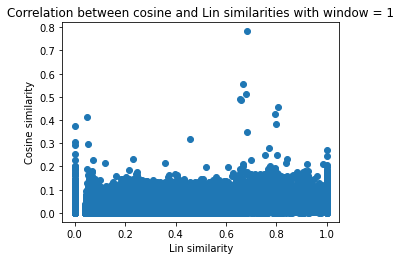

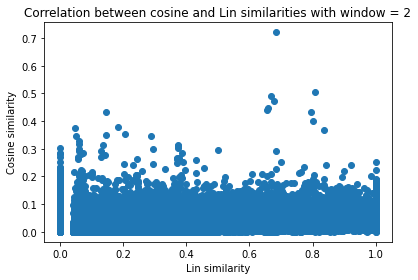

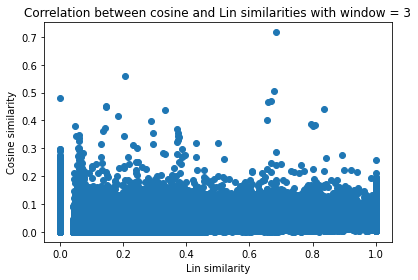

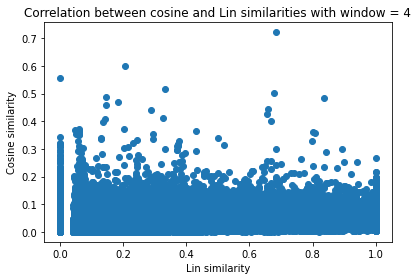

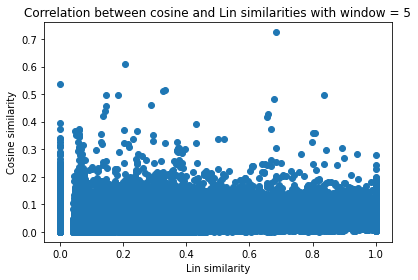

In [ ]:
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)
columns = 2
rows = 3

for i in range(1, columns*rows+1):
  if i > len(similarity_measure_2):
    break
  else:
    fig.add_subplot(rows, columns, i)
    plt.scatter(similarity_measure_1, similarity_measure_2[i - 1])
    plt.title('Correlation between cosine and Lin similarities with window = ' + str(i))
    plt.xlabel('Lin similarity')
    plt.ylabel('Cosine similarity')
    plt.tight_layout()
    plt.show()

**Discussion:** As can be seen, no matter the window size chosen (at least from 1 to 5), the correaltion between Lin and cosine similarity is almost the same (remains constant). In particular, although there are changes along the Lin similarity values (x-axis), the cosine similarty remains rather low (in general below, aprozimately, 0.3).

,Window size,Spearman's correlation
0,1,0.194886
1,2,0.198299
2,3,0.196734
3,4,0.193100
4,5,0.190206


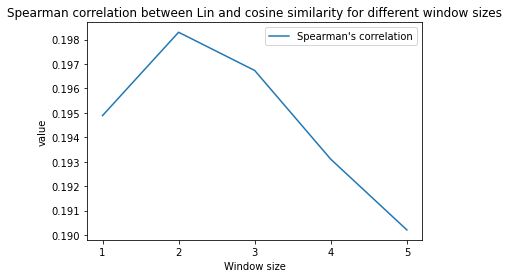

In [ ]:
cols = ["Window size", "Spearman's correlation"]

df = pd.DataFrame(list(zip(window_sizes, correlations)),columns = cols)
display(df)

ax = df.plot(kind='line',x=cols[0],y=cols[1],
               title="Spearman correlation between Lin and cosine similarity for different window sizes")
# set xticks
ax.set_xticks(window_sizes)
# set the y-axis label
ax.set_ylabel("value")
# set legend
ax.legend(loc='best')
plt.show()

**Discussion:** Consistently with the previous scatter plots, Spearman's correlation has very similar values for each widow size chosen. Thus, it shows that cosine similarity is almost the same in the window size range from 1 to 5. It could be interesting to see whether cosine similarity might vary if the window size is set to a larger number. The main reason why I din not test that is due to computational costs. Running the 'test_similarity' function for the window sizes shown above (1-5) took around 10 minutes. Setting a higher window size implies that more distant features will be part of the vector representation of the target word. So, it crucial to investigate whether relevant features of a word can, on average, occur in distant positions from it. 

In [ ]:
##This code will word count all of the markdown cells in the notebook saved at filepath
##Running it before providing any answers shows that the questions have a word count of 388

import io
from nbformat import current

filepath="/content/drive/My Drive/Sussex AI/Applied NLP/1st Assignment/ANLPassignment.ipynb"
question_count=754

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
      word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Submission length is 2538
